In [10]:
import pandas as pd
import re
import nltk
import pyap
import googlemaps

ModuleNotFoundError: No module named 'pyap'

## Load data

In [6]:
with open('../data/data.txt', 'r') as f: 
    data = f.readlines()
f.close()

In [7]:
data = [x.rstrip().lstrip().strip('\",') for x in data]

In [8]:
print (data)

['Marks and Spencers Ltd', 'M&S Limited', 'NVIDIA Ireland', 'SLOUGH SE12 2XY', '33 TIMBER YARD,LONDON, L1 8XY', '44 CHINA ROAD, KOWLOON, HONG KONG', 'XYZ 13423 / ILD', 'ABC/ICL/20891NC', 'HARDWOOD TABLE', 'PLASTIC BOTTLE', 'LONDON', 'HONG KONG', 'ASIA', 'JP Morgan & Chase Co.', 'ICNAO02312', 'TOYS', '5 Time Square, New York, NY 10036', 'COMPUTER PARTS', 'INTEL CORPORATION', 'INTEL CO']


# Part 1
#### non machine learning approach

In [223]:
company_str = ['Corporation', 'Inc.', 'Co.', 'Corp', 'Cooperatives', 'Ltd', 'Limited', 'Company', \
                  'L.P.', 'Incorporated', 'International']
def get_company(data, search_str): 
    search_str = re.compile("("+"|".join(search_str)+')$', re.IGNORECASE)
    company_list = list(filter(search_str.search, data))
    return company_list

In [224]:
print ('company_name: ', get_company(data, company_str))
# NVIDIA Ireland will not be captured 

company_name:  ['Marks and Spencers Ltd', 'M&S Limited', 'JP Morgan & Chase Co.']


In [356]:
'''
It's better to filter down to possible address/location data 
(using features like x, y coordinates) before using googlemaps
'''
gmaps = googlemaps.Client(key='#######################################')
address_list = {}
for d in data: 
    code = gmaps.geocode(d)
    if len(code)>0 :
        #print (d, '-----', code['type'])
        address_list[d] = code

In [554]:
print ('------Sample output from googlemaps------')
print (list(address_list.keys())[0])
print (list(address_list.values())[0])

------Sample output from googlemaps------
SLOUGH SE12 2XY
[{'access_points': [], 'address_components': [{'long_name': 'Slough', 'short_name': 'Slough', 'types': ['locality', 'political']}, {'long_name': 'England', 'short_name': 'England', 'types': ['administrative_area_level_1', 'political']}, {'long_name': 'United Kingdom', 'short_name': 'GB', 'types': ['country', 'political']}], 'formatted_address': 'Slough, UK', 'geometry': {'bounds': {'northeast': {'lat': 51.5458426, 'lng': -0.4900443}, 'southwest': {'lat': 51.4679841, 'lng': -0.6601652}}, 'location': {'lat': 51.51053839999999, 'lng': -0.5950405999999999}, 'location_type': 'APPROXIMATE', 'viewport': {'northeast': {'lat': 51.5458426, 'lng': -0.4900443}, 'southwest': {'lat': 51.4679841, 'lng': -0.6601652}}}, 'place_id': 'ChIJqZKefkJjdkgRBgILuVKjbLE', 'types': ['locality', 'political']}]


In [403]:
def get_adress_location(google_parsed): 
    return_address = []
    reurn_location = []
    address_keys = ['establishment', 'point_of_interest']
    location_keys = ['country', 'continent', 'locality']
    for k, v in google_parsed.items():
        if set(address_keys).issubset(v[0]['types']):
            return_address.append(k)
        elif any(x in location_keys for x in v[0]['types']):
            reurn_location.append(k)
    return return_address, reurn_location

In [417]:
adress_location = get_adress_location(address_list)
print ('company_address: ', adress_location[0])
print ('location: ', adress_location[1])

company_address:  ['33 TIMBER YARD,LONDON, L1 8XY', '44 CHINA ROAD, KOWLOON, HONG KONG', 'HARDWOOD TABLE', 'PLASTIC BOTTLE', 'JP Morgan & Chase Co.']
location:  ['SLOUGH SE12 2XY', 'LONDON', 'HONG KONG', 'ASIA']


In [309]:
def get_serial_number(data): 
    # '/' is the only common feature in the 2 given serial numbers 
    return [d for d in data if '/' in d]

In [310]:
print ('serial_number: ', get_serial_number(data))

serial_number:  ['XYZ 13423 / ILD', 'ABC/ICL/20891NC']


In [321]:
# trying to see if there is any pattern 
sentence = ['ABC/ICL/20891NC', 'XYZ 13423 / ILD']
tokens = [nltk.word_tokenize(s) for s in sentence]
print ('Serial number pos tagging:\n', [nltk.pos_tag(t) for t in tokens])
'''
 If there is a pattern, for example ($,CD,NNP,NNP), then we can use 
 pattern = r'NP: {<$><CD><NNP>*}'
 cp = nltk.RegexpParser(pattern)
 and then train IOB
 This requires well formatted input
'''

Serial number pos tagging:
 [[('ABC/ICL/20891NC', 'NN')], [('XYZ', '$'), ('13423', 'CD'), ('/', 'NNP'), ('ILD', 'NNP')]]


## Part 2

In [1]:
from sklearn.feature_extraction import DictVectorizer, FeatureHasher
from sklearn.feature_extraction.text import TfidfVectorizer
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
import numpy as np
import pickle as pk

In [2]:
'''
I only used TFIDF matrix as feature for the sake of demonstration. 
Ideally there will be other useful features
'''
tfidf_vectorizer = TfidfVectorizer(max_df=1, max_features=200000,min_df=1, use_idf=True, ngram_range=(1,2))

In [3]:
tfidf_vectorizer

TfidfVectorizer(max_df=1, max_features=200000, ngram_range=(1, 2))

In [15]:
def structure_new_df(text_strings, vector_matrix, model): 
    df = pd.DataFrame(columns = ['text', 'vector', '2D', 'cluster'])
    mat_array = vector_matrix.tolist()
    #print (vector_matrix.shape)
    df['text'] = text_strings
    df['vector'] = mat_array
    pca = PCA(n_components=2).fit(vector_matrix)
    
    data2D = pca.transform(vector_matrix).tolist()
    df['2D'] = data2D
    df['cluster'] = df['vector'].apply(lambda x: 'cluster_'+str(model.predict(np.reshape(x, (-1, len(x))))[0]))
    return df

def generate_scatter_plot(df): 
    plt.clf()
    data2D = np.array(df['2D'].tolist())
    n = df.index
    plt.scatter(data2D[:,0], data2D[:,1])
    for i, txt in enumerate(n):
        plt.annotate(txt, (data2D[i,0], data2D[i,1]))
    plt.show()
    #return plot

In [16]:
# create initial clusters 
tfidf_init = tfidf_vectorizer.fit_transform(data).todense()
kmeans = KMeans(n_clusters=4, random_state = 0).fit(tfidf_init)
init_df = structure_new_df(data, tfidf_init, kmeans)

(20, 76)


Initial vector and plot

In [12]:
init_df

,text,vector,2D,cluster
0,Marks and Spencers Ltd,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[-2.688821387764051e-17, -2.2551405187698492e-17]",cluster_1
1,M&S Limited,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[-0.3013969212290024, 0.010946617216642678]",cluster_1
2,NVIDIA Ireland,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[-0.3579928977872876, 0.4803383626756066]",cluster_2
3,SLOUGH SE12 2XY,"[0.0, 0.0, 0.0, 0.0, 0.4472135954999579, 0.0, ...","[-0.30817590330924566, -0.24700289061207908]",cluster_1
4,"33 TIMBER YARD,LONDON, L1 8XY","[0.0, 0.0, 0.0, 0.0, 0.0, 0.3162277660168379, ...","[-0.17732898634670424, -0.11441612228388383]",cluster_1
5,"44 CHINA ROAD, KOWLOON, HONG KONG","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.35355339...","[0.01683857452950952, 0.02015767225199336]",cluster_1
6,XYZ 13423 / ILD,"[0.0, 0.4472135954999579, 0.4472135954999579, ...","[-0.09271057026878268, -0.03289804860726471]",cluster_1
7,ABC/ICL/20891NC,"[0.0, 0.0, 0.0, 0.4472135954999579, 0.0, 0.0, ...","[-0.25268649340319055, -0.08072548327504525]",cluster_1
8,HARDWOOD TABLE,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.49544944449308437, -0.09052650961925993]",cluster_1
9,PLASTIC BOTTLE,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.37960165036850696, 0.10759838419227344]",cluster_1


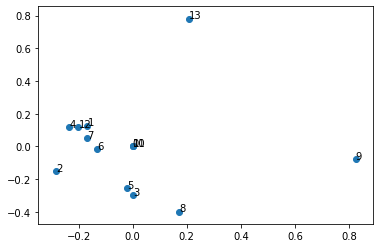

In [1073]:
init_plt = generate_scatter_plot(init_df)

In [1074]:
def get_prediction_df(current_df, vectorizer, k, new_string, plot = True): 
    current_dic = dict(zip(current_df['text'], current_df['vector']))
    corpus = current_df['text'].tolist()
    if new_string and new_string not in corpus: 
        print (new_string, '--This is a new string')
        corpus += [new_string]  
        X = tfidf_vectorizer.fit_transform(corpus)
        tfidf_matrix = X.todense()
        kmeans = KMeans(n_clusters=4, random_state = 0).fit(tfidf_matrix)
        df = structure_new_df(corpus, tfidf_matrix, model = kmeans)
    else: 
        print (new_string, '--String already exist')
        row = current_df[current_df['text'] == new_string]
        df = current_df.append(row)
    if plot == True: 
        new_plot = generate_scatter_plot(df)
    return df

def print_clusters(df):
    cluster_dict = df.groupby('cluster')['text'].apply(list).to_dict()
    for k, v, in cluster_dict.items():
        print (k, v)

1) add the same string twice 
<br>everytime when a new vocab is added, tfidf_vectorizer changes dimensions which means the plot coordinates change 

420 5th ave, New York, NY --This is a new string


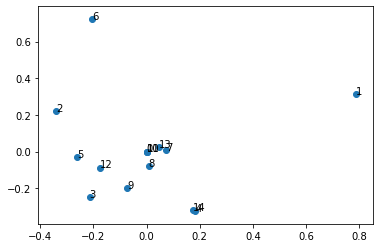

In [1075]:
c_df = init_df
c_df = get_prediction_df(c_df, tfidf_vectorizer, k = 4, new_string = '420 5th ave, New York, NY', plot = True)

420 5th ave, New York, NY --String already exist


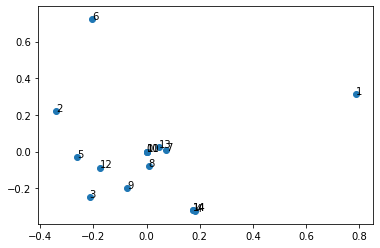

In [1076]:
c_df = get_prediction_df(c_df, tfidf_vectorizer, k = 4, new_string = '420 5th ave, New York, NY', plot = True)

2) Add 2 new strings

standing desk --This is a new string
American Airlines, Inc. --This is a new string


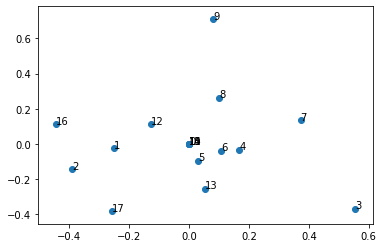

In [1077]:
c_df = get_prediction_df(c_df, tfidf_vectorizer, k = 4, new_string = 'standing desk', plot = False)
c_df = get_prediction_df(c_df, tfidf_vectorizer, k = 4, new_string = 'American Airlines, Inc.', plot = True)

In [1078]:
print_clusters(c_df)

cluster_0 ['M&S Limited']
cluster_1 ['33 TIMBER YARD,LONDON, L1 8XY']
cluster_2 ['NVIDIA Ireland']
cluster_3 ['Marks and Spencers Ltd', 'SLOUGH SE12 2XY', '44 CHINA ROAD, KOWLOON, HONG KONG', 'XYZ 13423 / ILD', 'ABC/ICL/20891NC', 'HARDWOOD TABLE', 'PLASTIC BOTTLE', 'LONDON', 'HONG KONG', 'ASIA', 'JP Morgan & Chase Co.', '420 5th ave, New York, NY', '420 5th ave, New York, NY', 'standing desk', 'American Airlines, Inc.']


From both plot and the 2D column, we can see some of the data points are very close, such as
<br> #10, London
<br> #11, Hong Kong
<br> #14 and #15, 420 5th ave, New York, NY	

In [1079]:
c_df

,text,vector,2D,cluster
0,Marks and Spencers Ltd,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[3.5561831257524545e-17, -2.688821387764051e-17]",cluster_3
1,M&S Limited,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[-0.24970247013266395, -0.022986854595491844]",cluster_0
2,NVIDIA Ireland,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[-0.38969841831380486, -0.14110210241919746]",cluster_2
3,SLOUGH SE12 2XY,"[0.0, 0.0, 0.0, 0.4472135954999579, 0.0, 0.0, ...","[0.5556074599400634, -0.3679424616514372]",cluster_3
4,"33 TIMBER YARD,LONDON, L1 8XY","[0.0, 0.0, 0.0, 0.0, 0.31622776601683794, 0.31...","[0.16713344800753593, -0.03213755917498132]",cluster_1
5,"44 CHINA ROAD, KOWLOON, HONG KONG","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.3535533905932...","[0.029972475844704964, -0.09508358578948783]",cluster_3
6,XYZ 13423 / ILD,"[0.4472135954999579, 0.4472135954999579, 0.0, ...","[0.10683283895197068, -0.03835969220527145]",cluster_3
7,ABC/ICL/20891NC,"[0.0, 0.0, 0.4472135954999579, 0.0, 0.0, 0.0, ...","[0.37259797777259535, 0.13563917705376807]",cluster_3
8,HARDWOOD TABLE,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.10147518128957445, 0.2629599319323672]",cluster_3
9,PLASTIC BOTTLE,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.08044645453632654, 0.7121306014383066]",cluster_3
